# Project 1. Denoising Network

In this project, you're going to implement a neural network to denoise images, there are several parts you need to implement to make the whole pipeline complete.

1. Dataset
2. Metrics
3. Networks
4. Training

## 1. Dataset

In this project we are going to use an image dataset of 400 grayscale 180*180 images as our dataset, use command below to download the dataset

In [1]:
!wget 'https://www.dropbox.com/s/dn6jv1qw5bpdcs9/ImageSet.zip?dl=0' -O ImageSet.zip
!unzip -q -o ImageSet.zip

--2024-04-06 07:01:00--  https://www.dropbox.com/s/dn6jv1qw5bpdcs9/ImageSet.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/dn6jv1qw5bpdcs9/ImageSet.zip [following]
--2024-04-06 07:01:00--  https://www.dropbox.com/s/raw/dn6jv1qw5bpdcs9/ImageSet.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc46d390e617c03c0b1e43b091ac.dl.dropboxusercontent.com/cd/0/inline/CQcIUfrEWpMGH-JCBJoVx_nTS-OGtrLv-3EUAFOhpJDthW9EZkAQc30w132DZC_Rn-BeucPSsUT-EGzXcXtlXfsthVUMnB3-WFWtscT6zO36FZnSGRk9x6VnskzafoqQ0kRgu6xutt-UXkcssCIsUGx-/file# [following]
--2024-04-06 07:01:01--  https://uc46d390e617c03c0b1e43b091ac.dl.dropboxusercontent.com/cd/0/inline/CQcIUfrEWpMGH-JCBJoVx_nTS-OGtrLv-3EUAFOhpJDthW9EZkAQc30w132DZC_Rn-BeucPSsUT-EGzXcXtlXfsthVUMnB

Now you should have a folder called ImageSet, and there're 400 images in it

In [2]:
!ls ImageSet | wc -l

400


Now you need to implement two classes, TrainingSet and TestingSet, you should first split your dataset into 350 images and 50 images. TrainingSet should use the 350 images to form a dataset, with each entry being a pair of image tensors, and the first image should be a noisy version of the second original image. In other words, `training_set[i]` should return `[noisy_image(=original_image + noise), original_image]`, and images should be tensors of shape $C\times H\times W$, in this case, $1\times 180\times 180$

TestingSet is the same thing with the remaining 50 images.
1. Please refer to the following code to add noise
```python
def add_noise(img):
    noise = torch.randn(img.size()).mul_(self.sigma/255.0)
    noisy = img + noise
    noisy[torch.where(noisy > 1)] = 1
    noisy[torch.where(noisy < 0)] = 0
    return noisy
```
2. Also refer to the following code as how to read images from file to memory
```python
class RawImageSet(torch.utils.data.Dataset):
    def __init__(self, root):
        self.root = root
        self.all_image_files = os.listdir(root)

    def __getitem__(self, index):
        image_path = os.path.join(self.root, self.all_image_files[index])
        img = PIL.Image.open(image_path)
        return transforms.ToTensor()(img)

    def __len__(self):
        return len(self.all_image_files)
```

In [3]:
import torch
import PIL
import os
from torchvision import transforms

class RawImageSet(torch.utils.data.Dataset):
    '''
    This class is used to load the raw image dataset.

    Args:
        root: the root directory of the image dataset.

    Returns:
        A PyTorch dataset object.
    '''
    def __init__(self, root):
        self.root = root
        self.all_image_files = os.listdir(root)
        self.sigma = 10

    def __getitem__(self, index):
        '''
        This function should return one sample of the dataset.

        Args:
            index: the index of the sample.

        Returns:
            A tensor of the image.
        '''
        image_path = os.path.join(self.root, self.all_image_files[index])
        img = PIL.Image.open(image_path)
        img = img.convert('L')
        return transforms.ToTensor()(img)

    def __len__(self):
        return len(self.all_image_files)

    def add_noise(self,img):
        noise = torch.randn(img.size()).mul_(self.sigma/255.0)
        noisy = img + noise
        noisy[torch.where(noisy > 1)] = 1
        noisy[torch.where(noisy < 0)] = 0
        return noisy



# implement your TrainingSet and TestingSet here
class TrainingSet(RawImageSet):

    def __init__(self) -> None:
        super().__init__('ImageSet')
        self.all_image_files = self.all_image_files[:350]
        self.items = []
        self.initialize()


    def __getitem__(self, index):
        '''
        This function should return one sample of the dataset.

        Args:
            index: the index of the sample.

        Returns:
            A tensor of the noisy image and the original image.
        '''
        img = super().__getitem__(index)
        return [self.add_noise(img), img]

    def initialize(self):
        self.items = []
        for i in range(len(self.all_image_files)):
            img = self.__getitem__(i)
            self.items.append(img)



class TestingSet(RawImageSet):

    def __init__(self) -> None:
        super().__init__('ImageSet')
        self.all_image_files = self.all_image_files[350:]
        self.items = []
        self.initialize()


    def __getitem__(self, index):
        '''
        This function should return one sample of the dataset.

        Args:
            index: the index of the sample.

        Returns:
            A tensor of the noisy image and the original image.
        '''
        img = super().__getitem__(index)
        return [self.add_noise(img), img]

    def initialize(self):
        self.items = []
        for i in range(len(self.all_image_files)):
            img = self.__getitem__(i)
            self.items.append(img)


# from data import TrainingSet, TestingSet # use this command to use our provided implementation as a placeholder


You can use the following code block to check if your implementation is correct, first, there should be **no error**, second, the shape of image should be **`[1, 180, 180]`**, and finally, in the drawing area, the **left hand side image should be noisier than the right hand side image**, but they should be images of the same thing.

Shape of image: torch.Size([1, 180, 180])


Text(0.5, 1.0, 'original example')

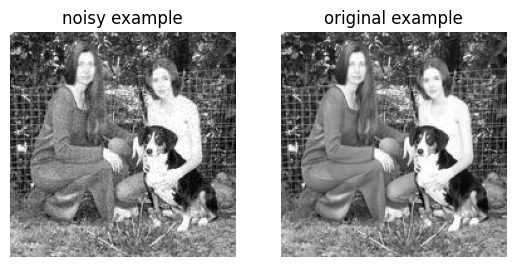

In [4]:
training_set = TrainingSet()
testing_set = TestingSet()
assert len(training_set) == 350
assert len(testing_set) == 50
print(f'Shape of image: {training_set[0][0].shape}')

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2)
axes[0].imshow(training_set[0][0][0], cmap='gray')
axes[0].axis('off')
axes[0].set_title('noisy example')
axes[1].imshow(training_set[0][1][0], cmap='gray')
axes[1].axis('off')
axes[1].set_title('original example')

## 2. Metrics
To quantify how noisy an image is compared to the original one, we're going to use PSNR, please implement a function `psnr` to return the psnr score.

Refer to https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio about the formula of PSNR

Note:
1. higher PSNR means noise is relatively smaller, the PSNR of the original image is positive infinity, because the noise is zero.
2. the psnr is a symetric function, meaning the psnr of a noisy image with respect to the original one is the same as the psnr of the original image with respect to the noisy one.

In [5]:
# implement your psnr function
def psnr(original, noisy):
    '''
    This function should return the PSNR value of the two images.

    Args:
        original: the original image.
        noisy: the noisy image.

    Returns:
        The PSNR value.
    '''
    mse = torch.mean((original - noisy) ** 2)
    if mse == 0: return float(100)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

# from metrics import psnr # to skip this part

Run the following code to check if the implementation is correct, the expected output should be about 7.96

In [6]:
import torch
test_original = torch.tensor([[0.1, 0.2], [0.3, 0.4]])
test_noisy = torch.tensor([[0.5, 0.6], [0.7, 0.8]])
print(f'PSNR score: {psnr(test_original, test_noisy)}')

PSNR score: 7.958800315856934


And we can calculate the psnr score for the noisy image pair we showed above, the score should be aroud 28, but there could be exception.

In [7]:
print(f'PSNR score for example images: {psnr(training_set[0][1], training_set[0][0])}')

PSNR score for example images: 28.254289627075195


## 3. Network
Now that we got dataset ready and metrics ready, we start preparing the network. You need to define a class `DenoiseNetwork` as your network class.

The goal of your network is to take the noisy image as input and output the predicted **noise**. First of all, the input and the output of the network should have the same size, the main idea is to predict the original image first by going through several CNN layers, and then use the input noisy image to deduct predicted original image to get the noise, the pseudo code should be like:
```python
class DenoiseNetwork(nn.Module):
    def __init__(self):
        define some cnn layers and other necessary components
    
    def forward(self, x):
        predicted_original_image = cnn_network(x)
        noise = x - predicted_original_image
        return noise
```
Then calculate the mean squared error between the predicted noise and the truth noise as our loss, and try to minimize it.

Tips:
1. you can use nn.MSELoss as your loss function
2. Use Adam instead of SGD as your optimizer, initial learning rate set to 0.001
3. Use `torch.nn.init.orthogonal_` to initialize the `weight` of your cnn layers as orthogonal matrices, and use `torch.nn.init.constant_` to fill the `bias` of your cnn layers with `0`s.
4. Try dropout, batchnorm etc. to improve the results (training speed, restored results etc.)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np


class DenoiseNetwork(nn.Module):
    def __init__(self):
        super(DenoiseNetwork, self).__init__()
        # Initial convolution block
        self.conv1 = nn.Conv2d(1, 2, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(2)

        # Define more convolution blocks with increasing channels
        self.conv2 = nn.Conv2d(2, 4, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(4)
        self.conv3 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(8)
        self.conv4 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(16)
        self.conv5 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv6 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.conv7 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(128)

        # Gradually decrease the number of channels
        self.conv8 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.bn8 = nn.BatchNorm2d(64)
        self.conv9 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.bn9 = nn.BatchNorm2d(32)
        self.conv10 = nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1) # Final layer to reduce to 1 channel

        self.relu = nn.ReLU(inplace=False)

        self._initialize_weights()

    def forward(self, x):
        original_x = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.relu(self.bn6(self.conv6(x)))
        x = self.relu(self.bn7(self.conv7(x)))
        x = self.relu(self.bn8(self.conv8(x)))
        x = self.relu(self.bn9(self.conv9(x)))
        predicted_original_image = self.conv10(x)

        noise = predicted_original_image
        return noise

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=False),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=False)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.up1 = Up(768, 256)
        self.up2 = Up(384, 128)
        self.up3 = Up(192, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.outc(x)
        return logits


class DnCNN(nn.Module):
    def __init__(self, depth=17, n_channels=64, image_channels=1):
        super(DnCNN, self).__init__()
        layers = []

        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=3, stride=1, padding=1, bias=True))
        layers.append(nn.ReLU(inplace=True))

        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=3, stride=1, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))

        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=3, stride=1, padding=1, bias=False))

        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        out = self.dncnn(x)
        return x - out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)


class DoubleConv2(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.25):
        super(DoubleConv2, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=False),
            nn.Dropout(dropout_prob),  # 在第一个ReLU之后添加Dropout层
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=False)
        )
        self._initialize_weights()

    def forward(self, x):
        return self.double_conv(x)
    
    def _initialize_weights(self):
        for m in self.double_conv:
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                init.constant_(m.bias, 0)


class Down2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down2, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv2(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up2(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up2, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        
        self.conv = DoubleConv2(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv2, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self._initialize_weights()

    def forward(self, x):
        return self.conv(x)
    
    def _initialize_weights(self):
        init.orthogonal_(self.conv.weight)
        init.constant_(self.conv.bias, 0)

class UNet2(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet2, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv2(n_channels, 64)
        self.down1 = Down2(64, 128)
        self.down2 = Down2(128, 256)
        self.down3 = Down2(256, 512)
        self.up1 = Up2(768, 256)
        self.up2 = Up2(384, 128)
        self.up3 = Up2(192, 64)
        self.outc = OutConv2(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.outc(x)
        return logits







# check if mps is available, if not use cuda
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cuda')
# device = torch.device('cpu')

# net = DenoiseNetwork().to(device)
net = UNet(n_channels=1, n_classes=1).to(device)
# net = DnCNN().to(device)

# from model import DenoiseNetwork # to skip this part
# net = DenoiseNetwork().to(device)


Here're some basic tests to see if your network can at least run through an example image, this is expected to produce no error.

In [9]:
example_batch = training_set[0][0].unsqueeze(0)
assert net(example_batch.to(device)).shape == example_batch.shape

Now we need a quantitative score to indicate how well a network performs. Previously we have defined the psnr function, but it only calculates psnr of an image pair, we need to calculate two scores to see how well the network denoises, the first is the mean psnr score of all noisy images, which indicates how noisy these unprocessed images are, and then assume we have the network ready, we can use the network to predict the noise, and deduct the noise from the noisy images to produce restored images, then we calculate the mean psnr score of these restored images with respect to the original images, and this score indicate how noisy the restored images are. If everything works out fine, we should be able to observe a higher psnr on the restored images.

You need to define a `mean_psnr` function that takes a dataset and a network as input and calculate the mean psnr scores of original noisy images across the whole dataset and mean psnr of restored images processed by the network.

In [10]:
# implement your mean_psnr function
from torch.utils.data import dataloader
def mean_psnr(dataset, network):
    '''
    This function should return the mean PSNR value of the testing set.

    Args:
        testset: the testing set.
        net: the network model.

    Returns:
        The mean PSNR value.
    '''
    network.eval()  # Set the network to evaluation mode
    total_psnr_noisy = 0.0
    total_psnr_restored = 0.0
    total_images = 0
    if type(dataset) != dataloader.DataLoader:
        dataset = dataloader.DataLoader(dataset, batch_size=1, shuffle=False)
    with torch.no_grad():  # No need to track gradients
        # Iterate over the dataset and calculate the original and restored images PSNR
        for i, (noisy_img, original_img) in enumerate(dataset):
            noisy_img, original_img = noisy_img.to(device), original_img.to(device)

            # Predict the noise using the network
            predicted_noise = network(noisy_img)

            # Restore images by subtracting predicted noise from noisy images
            restored_img = predicted_noise

            # Calculate PSNR for the noisy and restored images
            psnr_noisy = psnr(noisy_img, original_img)
            psnr_restored = psnr(restored_img, original_img)

            total_psnr_noisy += psnr_noisy
            total_psnr_restored += psnr_restored

            total_images += 1

    mean_psnr_noisy = total_psnr_noisy / total_images
    mean_psnr_restored = total_psnr_restored / total_images

    return mean_psnr_noisy, mean_psnr_restored

We can calculte the mean psnr on `testing_set`

In [11]:
mean_psnr(testing_set, net)

(tensor(28.2196, device='cuda:0'), tensor(5.5748, device='cuda:0'))

If your code is correct, you should see the mean psnr of original images should be around 28, and the psnr of network processed images is much smaller, which means, a randomly initialzed network adds even more noise, you should see this by displaying.

tensor(4.8088, device='cuda:0', grad_fn=<MulBackward0>)


Text(0.5, 1.0, 'restored')

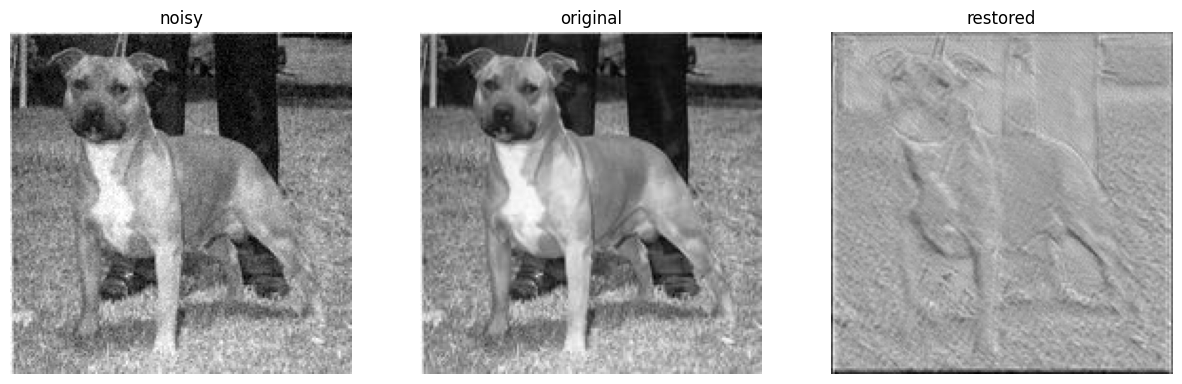

In [12]:
noisy_image, original_image = testing_set[0]
noisy_image = noisy_image.to(device)
predicted_noise = net(noisy_image.unsqueeze(0)).squeeze(0)
restored_image = predicted_noise
print(psnr(original_image.to(device),restored_image.to(device)))

fig, axes = plt.subplots(1,3)
fig.set_figwidth(15)
axes[0].imshow(noisy_image[0].cpu(), cmap='gray')
axes[0].axis('off')
axes[0].set_title('noisy')
axes[1].imshow(original_image[0], cmap='gray')
axes[1].axis('off')
axes[1].set_title('original')
axes[2].imshow(restored_image[0].cpu().detach(), cmap='gray')
axes[2].axis('off')
axes[2].set_title('restored')

## 4. Training
Now that we got everything ready, we should start training, in the next section, you need to implement the training process, that includes defining criteria, setting up optimizer, going through several epochs to train the network, during the training, you should also analyze the psnr scores to see how it goes in terms of quantified performance.

Checklist:
1. define dataloader, recommend batch size starting from 32
2. criteria
3. optimizer
4. (optional) consider using functions in torch.optim.lr_scheduler to adjust your learning rate, because smaller learning rate might work better in the later period of training, similar to fine adjustment. Reference: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
5. during each iteration, you need to 1. get the noisy image and the original image 2. calculate predicted noise from network, use MSE to calculate the distance between predicted noise and true noise 3. reset gradients to zero 3. use the distance as loss to backward the network to get gradients 4. perform learning with the gradients using optimizer
6. From time to time (e.g. each epoch), calculate PSNR on testing_set

In [13]:
# implement your training steps
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# fill your code here
train_loader = DataLoader(training_set, batch_size=48, shuffle=True)
test_loader = DataLoader(testing_set, batch_size=48, shuffle=False)
criteria = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)


def train_model(model, train_loader, test_loader, optimizer, scheduler, criteria, num_epochs=25, device='cpu'):
    model.to(device)
    print(f'Training on {device}')
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        # Iterate over data
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            loss = 100 - psnr(labels,outputs)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Adjust learning rate based on the scheduler's strategy
        scheduler.step(epoch_loss)

        # Evaluate the model on test dataset using mean_psnr
        mean_psnr_noisy, mean_psnr_restored = mean_psnr(test_loader, model)

        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch+1}/{num_epochs}, LR: {current_lr}, Mean PSNR (Noisy): {mean_psnr_noisy}, Mean PSNR (Restored): {mean_psnr_restored}, Loss: {epoch_loss}')


    print('Training complete')

def psnr_in_torch(img1, img2, max_pixel=1.0):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0: return float(100)
    return 20 * torch.log10(max_pixel / torch.sqrt(mse))


train_model(net, train_loader, test_loader, optimizer, scheduler, criteria, num_epochs=150, device=device)

Training on cuda
Epoch 1/150, LR: 0.001, Mean PSNR (Noisy): 28.18402099609375, Mean PSNR (Restored): -27.880516052246094, Loss: 95.35238577706473
Epoch 2/150, LR: 0.001, Mean PSNR (Noisy): 28.177879333496094, Mean PSNR (Restored): -17.24532699584961, Loss: 84.97905090332031
Epoch 3/150, LR: 0.001, Mean PSNR (Noisy): 28.194604873657227, Mean PSNR (Restored): 10.255012512207031, Loss: 77.30161669049944
Epoch 4/150, LR: 0.001, Mean PSNR (Noisy): 28.18618392944336, Mean PSNR (Restored): -9.416934967041016, Loss: 76.77948699951172
Epoch 5/150, LR: 0.001, Mean PSNR (Noisy): 28.180889129638672, Mean PSNR (Restored): 5.923692226409912, Loss: 76.65908320835659
Epoch 6/150, LR: 0.001, Mean PSNR (Noisy): 28.17721939086914, Mean PSNR (Restored): 4.840060234069824, Loss: 76.22183454241072
Epoch 7/150, LR: 0.001, Mean PSNR (Noisy): 28.197654724121094, Mean PSNR (Restored): 14.871286392211914, Loss: 73.41778019496373
Epoch 8/150, LR: 0.001, Mean PSNR (Noisy): 28.15789794921875, Mean PSNR (Restored): 

Now that your net is ready, we can re do the demonstration.

PSNR: tensor(34.4934, device='cuda:0', grad_fn=<MulBackward0>)
SSIM: 0.9972997307777405
(tensor(28.2200, device='cuda:0'), tensor(31.6834, device='cuda:0')) (tensor(28.2091, device='cuda:0'), tensor(31.8817, device='cuda:0'))


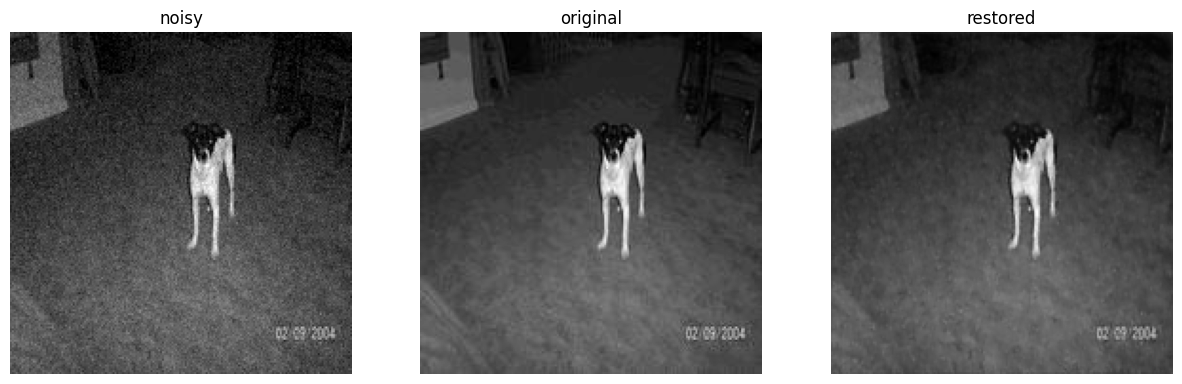

In [26]:
import random
from skimage.metrics import structural_similarity as ssim
import numpy as np


def gaussian_window(size, sigma, channels=1):
    """
    Generate a 1-D Gaussian window.
    """
    coords = torch.arange(size, dtype=torch.float)
    coords -= size // 2

    g = torch.exp(-(coords**2) / (2 * sigma**2))
    g /= g.sum()
    return g.view(1, 1, 1, -1).repeat(channels, 1, 1, 1)  # Repeat for each channel


def ssim_torch(img1, img2, window_size=11, window_sigma=1.5, size_average=True):
    """
    Calculate SSIM (Structural Similarity Index) between two images using PyTorch.
    """
    channel = 1
    window = gaussian_window(window_size, window_sigma).to(img1.device)
    window = window.expand(channel, 1, window_size, window_size)
    
    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)
    
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2
    
    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size//2, groups=channel) - mu1_mu2
    
    C1 = 0.01**2
    C2 = 0.03**2
    
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    
    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)



noisy_image, original_image = testing_set[random.randint(0,50)]
noisy_image = noisy_image.to(device)
predicted_noise = net(noisy_image.unsqueeze(0)).squeeze(0)
restored_image = predicted_noise
print("PSNR:",psnr(original_image.to(device),restored_image))
print(f"SSIM: {ssim_torch(original_image.cpu(),restored_image.cpu())}")



fig, axes = plt.subplots(1,3)
fig.set_figwidth(15)
axes[0].imshow(noisy_image[0].cpu(), cmap='gray')
axes[0].axis('off')
axes[0].set_title('noisy')
axes[1].imshow(original_image[0], cmap='gray')
axes[1].axis('off')
axes[1].set_title('original')
axes[2].imshow(restored_image[0].cpu().detach(), cmap='gray')
axes[2].axis('off')
axes[2].set_title('restored')
print(mean_psnr(testing_set,net),mean_psnr(training_set,net))
    

The network I trained here is a simple 3-layer low number of channel cnn network, and you can see it's already starting to work. Now try adjust some parameters/network structure to make it work even better. Write down your analysis to make a pdf report.

You need to submit two files, this ipynb file and a pdf report with your analysis.

#Marking Scheme:


*   Code implementation: 60%


> * Dataset 10%
> * Metrics 5%
> * Network 5% (only 5% because network overlaps with results, you need to adjust the network to improve the results anyway)
> * Training code 10%
> * reasonably good results 30% (with 10% bonus if the results are exceptional)


*   PDF report: 40%

> * Basic results demonstration (network introduction, denoising results showcase) 15%
> * Analysis and improvements 25% (You're supposed to clarify how do you make the network work, e.g. if you encounter some issues, what do you do to address them)

